<a href="https://colab.research.google.com/github/wonderplan/recommendation-service/blob/main/ML%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

df = pd.read_csv('./gen_data.csv')

# Remove irrelevant id column
df.drop(["Unnamed: 0"],  axis=1, inplace=True)

In [70]:
# Normalize the dataframe
scaler = StandardScaler()
normData = scaler.fit_transform(df)
df = pd.DataFrame(normData, columns=df.columns)

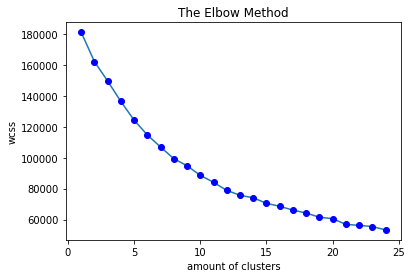

In [71]:
# Test cluster amount options
wcss = []
amount_clusters = range(1,25)

for n in amount_clusters:
    kmeans = KMeans(n_clusters=n, random_state=0)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)
    
plt.title('The Elbow Method')
plt.xlabel("amount of clusters")
plt.ylabel("wcss")
plt.plot(amount_clusters, wcss)
plt.plot(amount_clusters, wcss, 'bo')

In [72]:
# Using PCA to reduce the whole dataset to two columns
df_values = df.values
pca = PCA(n_components=2)
pca.fit_transform(df_values)
pca_values = pca.fit_transform(df_values)
pca_df = pd.DataFrame(data=pca_values, columns=['C1','C2'])

pca_df

,C1,C2
0,-3.623697,-0.773847
1,0.234006,-1.585331
2,-2.653102,0.922812
3,-2.286862,0.680579
4,-1.336534,0.346745
...,...,...
4020,0.601636,-0.359970
4021,-2.058988,-1.149028
4022,-2.239735,-0.859201
4023,1.985410,-3.387031


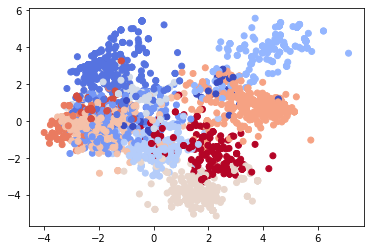

In [73]:
# Visualizing the model with 12 clusters
model = KMeans(n_clusters=12)
clustIndexes = model.fit_predict(df)

plt.scatter(pca_df['C1'], pca_df['C2'], c=clustIndexes, cmap="coolwarm")

In [76]:
# Testing out new user data
user_data = [[24,  1,  0,  0,  0,  1,  0,  5,  3,  3,  3,  4,  5,  5,  5,  5,
         5,  5,  5,  4,  5,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,
         0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0]]

user_cluster = model.predict(user_data)

user_cluster

array([7], dtype=int32)